# Regresión Lineal con regularización Lasso

En este cuaderno utilizaremos el método de regresión lineal con regularización Lasso para modelizar la diferencia de voto del PP entre las elecciones de 2016 y abril 2019.

En esta ocasión, por lo tanto, tendremos que combinar los dos daatset de estas dos elecciones, y para ello utilizaremos la equivalencia de las secciones en dos elecciones diferentes, algo que ya explicamos en los cuadernos de ETL.

Por lo demás, el proceso es muy similar al seguido en otros modelos: definición de la columna objetivo, procesado train y test, y modelización, en este caso con regresión lineal con regularización Lasso.

##Definición de columna objetivo

Comenzamos cargando las librerías necesarias, así como los datasets de 2016, abril 2019, y el de equivalencias de secciones.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [ ]:
strings = {'Sección' : 'str', 'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str', 'cod_sec' : 'str'}

In [ ]:
df_eleccion_A19 = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/gen_A19_unif_cols_prov.txt', dtype = strings)

In [ ]:
df_eleccion_A19

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
0,022019041010400101001,01,04,04001,0400101001,Andalucía,Almería,Abla,1014,768,0.757396,5,763,9,754,149,326,131,44,0,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,73,80,89,81,94,87,91,77,72,42,67,56,19,4,0,1249,635,614,0.269816,0.590072,0.140112,291.0,0.243986,0.232986,143.0,0.419580,0.559441,0.329493,9159.0,8788.0,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 149, 'PSOE': 326, 'Cs': 131, 'UP': 44, ...","[('PSOE', 326), ('PP', 149), ('Cs', 131), ('VO..."
1,022019041010400201001,01,04,04002,0400201001,Andalucía,Almería,Abrucena,1039,798,0.768046,6,792,7,785,127,380,91,60,0,113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,...,60,75,70,70,108,101,99,86,61,64,61,46,14,2,1,1202,637,565,0.278702,0.609817,0.111481,323.0,0.238390,0.268719,158.0,0.367089,0.601266,0.328482,8827.0,8107.0,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 127, 'PSOE': 380, 'Cs': 91, 'UP': 60, '...","[('PSOE', 380), ('PP', 127), ('VOX', 113), ('C..."
2,022019041010400301001,01,04,04003,0400301001,Andalucía,Almería,Adra,671,519,0.773472,4,515,1,514,162,131,68,44,0,103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,...,54,54,54,61,82,75,67,48,37,40,26,15,3,1,0,892,435,457,0.190583,0.643498,0.165919,7571.0,0.393871,8.487668,3036.0,0.399868,0.459157,0.286226,8965.0,8267.0,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 162, 'PSOE': 131, 'Cs': 68, 'UP': 44, '...","[('PP', 162), ('PSOE', 131), ('VOX', 103), ('C..."
3,022019041010400301002,01,04,04003,0400301002,Andalucía,Almería,Adra,1282,954,0.744150,13,941,7,934,239,241,166,62,0,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,...,108,158,162,150,140,119,103,67,49,37,30,14,7,1,0,1752,865,887,0.117009,0.647260,0.235731,7571.0,0.393871,4.321347,3036.0,0.399868,0.459157,0.286226,8599.0,7941.0,25677.0,23400.0,5381.0,4837.0,1815.0,1724.0,343.0,464.0,"{'PP': 239, 'PSOE': 241, 'Cs': 166, 'UP': 62, ...","[('PSOE', 241), ('PP', 239), ('VOX', 218), ('C..."
4,022019041010400301003,01,04,04003,0400301003,Andalucía,Almería,Adra,1535,1087,0.708143,20,1067,6,1061,274,252,170,67,0,282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,189,178,215,227,164,110,96,61,58,41,40,27,4,4,0,2240,1094,1146,0.104911,0.647768,0.247321,7571.0,0.393871,3.379911,3036.0,0.399868,0.459157,0.286226,8076.0,7150.0,22051.0,19687.0,5224.0,4044.0,1170.0,1198.0,416.0,476.0,"{'PP': 274, 'PSOE': 252, 'Cs': 170, 'UP': 67, ...","[('VOX', 282), ('PP', 274), ('PSOE', 252), ('C..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36312,022019041195200108011,19,52,52001,5200108011,Melilla,Melilla,Melilla,1605,1118,0.696573,9,1109,4,1105,250,194,168,38,0,167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,288,...,181,185,171,164,165,180,155,97,38,34,19,16,4,3,0,2480,1244,1236,0.085081,0.623387,0.291532,24290.0,0.193413,9.794355,11827.0,0.381331,0.398326,0.327464,16433.0,15847.0,66352.0,62632.0,11378.0,11119.0,1508.0,1274.0,167.0,166.0,"{'PP': 250, 'PSOE': 194, 'Cs': 168, 'UP': 38, ...

Dataset de 2016...

In [ ]:
df_eleccion_J16 = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-16-Jun/gen_J16_unif_cols_prov.txt', dtype = strings)

Dataset de equivalencia de secciones:

In [ ]:
equiv_secciones = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/similitud_secciones_def_REF.csv', dtype = 'str')

In [ ]:
equiv_secciones

,cod_sec_ref,CUSEC,CUMUN,CPRO,Elección,cod_ccaa_orig,cod_ccaa_ref,cercana N11_ref,cercana D15_ref,cercana J16_ref,cercana A19_ref,cercana N19_ref
0,022019041140100901001,0100901001,01009,01,02201904,16,14,022011111140100901001,022015121140100901001,022016061140100901001,022019041140100901001,022019111140100901001
1,022019041140101001002,0101001002,01010,01,02201904,16,14,022011111140101001002,022015121140101001002,022016061140101001002,022019041140101001002,022019111140101001002
2,022019041140103101001,0103101001,01031,01,02201904,16,14,022011111140103101001,022015121140103101001,022016061140103101001,022019041140103101001,022019111140103101001
3,022019041140103301001,0103301001,01033,01,02201904,16,14,022011111140103301001,022015121140103301001,022016061140103301001,022019041140103301001,022019111140103301001
4,022019041140103701001,0103701001,01037,01,02201904,16,14,022011111140103701001,022015121140103701001,022016061140103701001,022019041140103701001,022019111140103701001
...,...,...,...,...,...,...,...,...,...,...,...,...
181034,022011111195200108010,5200108010,52001,52,02201111,19,19,022011111195200108010,022015121195200108010,022016061195200108010,022019041195200108010,022019111195200108010
181035,022011111195200108011,5200108011,52001,52,02201111,19,19,022011111195200108011,022015121195200108011,022016061195200108011,022019041195200108011,022019111195200108011
181036,022011111195200108012,5200108012,52001,52,02201111,19,19,022011111195200108012,022015121195200108012,022016061195200108012,022019041195200108012,022019111195200108012
181037,022011111195200108013,5200108013,52001,52,02201111,19,19,022011111195200108013,022015121195200108013,022016061195200108013,022019041195200108013,022019111195200108013


In [ ]:
equiv_secciones['Elección'].value_counts()

02201911    36317
02201904    36317
02201512    36229
02201606    36215
02201111    35961
Name: Elección, dtype: int64

Tomaremos como base el dataset de abril del 2019, por lo que habrá que buscar el equivalente de sus secciones en 2016. Seleccionamos del dataset de equivalencias las de abril de 2019. 

In [ ]:
equiv_secciones = equiv_secciones.loc[equiv_secciones['Elección'] == '02201904']

In [ ]:
equiv_secciones

,cod_sec_ref,CUSEC,CUMUN,CPRO,Elección,cod_ccaa_orig,cod_ccaa_ref,cercana N11_ref,cercana D15_ref,cercana J16_ref,cercana A19_ref,cercana N19_ref
0,022019041140100901001,0100901001,01009,01,02201904,16,14,022011111140100901001,022015121140100901001,022016061140100901001,022019041140100901001,022019111140100901001
1,022019041140101001002,0101001002,01010,01,02201904,16,14,022011111140101001002,022015121140101001002,022016061140101001002,022019041140101001002,022019111140101001002
2,022019041140103101001,0103101001,01031,01,02201904,16,14,022011111140103101001,022015121140103101001,022016061140103101001,022019041140103101001,022019111140103101001
3,022019041140103301001,0103301001,01033,01,02201904,16,14,022011111140103301001,022015121140103301001,022016061140103301001,022019041140103301001,022019111140103301001
4,022019041140103701001,0103701001,01037,01,02201904,16,14,022011111140103701001,022015121140103701001,022016061140103701001,022019041140103701001,022019111140103701001
...,...,...,...,...,...,...,...,...,...,...,...,...
36312,022019041111509302002,1509302002,15093,15,02201904,12,11,022011111111509302002,022015121111509302002,022016061111509302002,022019041111509302002,022019111111509302002
36313,022019041111590203001,1590203001,15902,15,02201904,12,11,022011111111502601001,022015121111590203001,022016061111590203001,022019041111590203001,022019111111590203001
36314,022019041111503103003,1503103003,15031,15,02201904,12,11,022011111111503103003,022015121111503103003,022016061111503103003,022019041111503103003,022019111111503103003
36315,022019041012101701002,2101701002,21017,21,02201904,01,01,022011111012101701002,022015121012101701002,022016061012101701002,022019041012101701002,022019111012101701002


De ellas nos quedamos con las equivalentes en 2016, que son las que nos interesan.

In [ ]:
equiv_secciones_util = equiv_secciones[['cod_sec_ref', 'cercana J16_ref']]

In [ ]:
equiv_secciones_util

,cod_sec_ref,cercana J16_ref
0,022019041140100901001,022016061140100901001
1,022019041140101001002,022016061140101001002
2,022019041140103101001,022016061140103101001
3,022019041140103301001,022016061140103301001
4,022019041140103701001,022016061140103701001
...,...,...
36312,022019041111509302002,022016061111509302002
36313,022019041111590203001,022016061111590203001
36314,022019041111503103003,022016061111503103003
36315,022019041012101701002,022016061012101701002


Ahora hay que incorporar estas equivalencias al dataset de abril 2019, algo que haremos con un merge. Unificamos el nombre de la columna que utilizaremos como enlace.

In [ ]:
equiv_secciones_util = equiv_secciones_util.rename(columns = {'cod_sec_ref' : 'Sección'})

In [ ]:
equiv_secciones_util

,Sección,cercana J16_ref
0,022019041140100901001,022016061140100901001
1,022019041140101001002,022016061140101001002
2,022019041140103101001,022016061140103101001
3,022019041140103301001,022016061140103301001
4,022019041140103701001,022016061140103701001
...,...,...
36312,022019041111509302002,022016061111509302002
36313,022019041111590203001,022016061111590203001
36314,022019041111503103003,022016061111503103003
36315,022019041012101701002,022016061012101701002


In [ ]:
len(equiv_secciones_util['cercana J16_ref'].unique())

35929

In [ ]:
len(equiv_secciones_util['Sección'].unique())

36317

Y hacemos el merge. Vemos a la derecha del todo que ya tenemos la sección equivalente de las de abril de 2019 en 2016.

In [ ]:
df_eleccion_A19 = df_eleccion_A19.merge(equiv_secciones_util, how='left', on='Sección')

In [ ]:
df_eleccion_A19

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,cercana J16_ref
0,022019041010400101001,01,04,04001,0400101001,Andalucía,Almería,Abla,1014,768,0.757396,5,763,9,754,149,326,131,44,0,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,80,89,81,94,87,91,77,72,42,67,56,19,4,0,1249,635,614,0.269816,0.590072,0.140112,291.0,0.243986,0.232986,143.0,0.419580,0.559441,0.329493,9159.0,8788.0,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 149, 'PSOE': 326, 'Cs': 131, 'UP': 44, ...","[('PSOE', 326), ('PP', 149), ('Cs', 131), ('VO...",022016061010400101001
1,022019041010400201001,01,04,04002,0400201001,Andalucía,Almería,Abrucena,1039,798,0.768046,6,792,7,785,127,380,91,60,0,113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,...,75,70,70,108,101,99,86,61,64,61,46,14,2,1,1202,637,565,0.278702,0.609817,0.111481,323.0,0.238390,0.268719,158.0,0.367089,0.601266,0.328482,8827.0,8107.0,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 127, 'PSOE': 380, 'Cs': 91, 'UP': 60, '...","[('PSOE', 380), ('PP', 127), ('VOX', 113), ('C...",022016061010400201001
2,022019041010400301001,01,04,04003,0400301001,Andalucía,Almería,Adra,671,519,0.773472,4,515,1,514,162,131,68,44,0,103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,...,54,54,61,82,75,67,48,37,40,26,15,3,1,0,892,435,457,0.190583,0.643498,0.165919,7571.0,0.393871,8.487668,3036.0,0.399868,0.459157,0.286226,8965.0,8267.0,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 162, 'PSOE': 131, 'Cs': 68, 'UP': 44, '...","[('PP', 162), ('PSOE', 131), ('VOX', 103), ('C...",022016061010400301001
3,022019041010400301002,01,04,04003,0400301002,Andalucía,Almería,Adra,1282,954,0.744150,13,941,7,934,239,241,166,62,0,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,...,158,162,150,140,119,103,67,49,37,30,14,7,1,0,1752,865,887,0.117009,0.647260,0.235731,7571.0,0.393871,4.321347,3036.0,0.399868,0.459157,0.286226,8599.0,7941.0,25677.0,23400.0,5381.0,4837.0,1815.0,1724.0,343.0,464.0,"{'PP': 239, 'PSOE': 241, 'Cs': 166, 'UP': 62, ...","[('PSOE', 241), ('PP', 239), ('VOX', 218), ('C...",022016061010400301002
4,022019041010400301003,01,04,04003,0400301003,Andalucía,Almería,Adra,1535,1087,0.708143,20,1067,6,1061,274,252,170,67,0,282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,178,215,227,164,110,96,61,58,41,40,27,4,4,0,2240,1094,1146,0.104911,0.647768,0.247321,7571.0,0.393871,3.379911,3036.0,0.399868,0.459157,0.286226,8076.0,7150.0,22051.0,19687.0,5224.0,4044.0,1170.0,1198.0,416.0,476.0,"{'PP': 274, 'PSOE': 252, 'Cs': 170, 'UP': 67, ...","[('VOX', 282), ('PP', 274), ('PSOE', 252), ('C...",022016061010400301003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36312,022019041195200108011,19,52,52001,5200108011,Melilla,Melilla,Melilla,1605,1118,0.696573,9,1109,4,1105,250,194,168,38,0,167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,288,...,185,171,164,165,180,155,97,38,34,19,16,4,3,0,2480,1244,1236,0.085081,0.623387,0.291532,24290.0,0.193413,9.794355,11827.0,0.381331,0.398326,0.327464,16433.0,15847.0,66352.0,6

In [ ]:
len(df_eleccion_A19['cercana J16_ref'].unique())

35929

Como hemos tomado como base el dataset de abril de 2019, del de las elecciones de 2016 en realidad solo nos hace falta la columna del porcentaje del PP.

In [ ]:
df_eleccion_J16_util = df_eleccion_J16[['Sección', '% PP']]

In [ ]:
df_eleccion_J16_util

,Sección,% PP
0,022016061010400101001,0.328010
1,022016061010400201001,0.286486
2,022016061010400301001,0.554167
3,022016061010400301002,0.504630
4,022016061010400301003,0.542948
...,...,...
36188,022016061195200108011,0.472877
36189,022016061195200108012,0.588879
36190,022016061195200108013,0.509646
36191,022016061195200108014,0.581250


Haremos un merge del dataset reducido de 2016 que acabamos de definir, con el de abril de 2019. Para ello unificamos el nombre de la columna que utilizaremos como enlace.

In [ ]:
df_eleccion_J16_util = df_eleccion_J16_util.rename(columns = {'Sección' : 'cercana J16_ref', '% PP' : '% PP J16'})

In [ ]:
df_eleccion_J16_util

,cercana J16_ref,% PP J16
0,022016061010400101001,0.328010
1,022016061010400201001,0.286486
2,022016061010400301001,0.554167
3,022016061010400301002,0.504630
4,022016061010400301003,0.542948
...,...,...
36188,022016061195200108011,0.472877
36189,022016061195200108012,0.588879
36190,022016061195200108013,0.509646
36191,022016061195200108014,0.581250


Y hacemos el merge, a la derecha del todo hemos añadido el porcentage de voto correspondiente al voto al PP en 2016.

In [ ]:
df_eleccion_A19_merged = df_eleccion_A19.merge(df_eleccion_J16_util,  how='left', on='cercana J16_ref')

In [ ]:
df_eleccion_A19_merged

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,cercana J16_ref,% PP J16
0,022019041010400101001,01,04,04001,0400101001,Andalucía,Almería,Abla,1014,768,0.757396,5,763,9,754,149,326,131,44,0,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,89,81,94,87,91,77,72,42,67,56,19,4,0,1249,635,614,0.269816,0.590072,0.140112,291.0,0.243986,0.232986,143.0,0.419580,0.559441,0.329493,9159.0,8788.0,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 149, 'PSOE': 326, 'Cs': 131, 'UP': 44, ...","[('PSOE', 326), ('PP', 149), ('Cs', 131), ('VO...",022016061010400101001,0.328010
1,022019041010400201001,01,04,04002,0400201001,Andalucía,Almería,Abrucena,1039,798,0.768046,6,792,7,785,127,380,91,60,0,113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,...,70,70,108,101,99,86,61,64,61,46,14,2,1,1202,637,565,0.278702,0.609817,0.111481,323.0,0.238390,0.268719,158.0,0.367089,0.601266,0.328482,8827.0,8107.0,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 127, 'PSOE': 380, 'Cs': 91, 'UP': 60, '...","[('PSOE', 380), ('PP', 127), ('VOX', 113), ('C...",022016061010400201001,0.286486
2,022019041010400301001,01,04,04003,0400301001,Andalucía,Almería,Adra,671,519,0.773472,4,515,1,514,162,131,68,44,0,103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,...,54,61,82,75,67,48,37,40,26,15,3,1,0,892,435,457,0.190583,0.643498,0.165919,7571.0,0.393871,8.487668,3036.0,0.399868,0.459157,0.286226,8965.0,8267.0,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 162, 'PSOE': 131, 'Cs': 68, 'UP': 44, '...","[('PP', 162), ('PSOE', 131), ('VOX', 103), ('C...",022016061010400301001,0.554167
3,022019041010400301002,01,04,04003,0400301002,Andalucía,Almería,Adra,1282,954,0.744150,13,941,7,934,239,241,166,62,0,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,...,162,150,140,119,103,67,49,37,30,14,7,1,0,1752,865,887,0.117009,0.647260,0.235731,7571.0,0.393871,4.321347,3036.0,0.399868,0.459157,0.286226,8599.0,7941.0,25677.0,23400.0,5381.0,4837.0,1815.0,1724.0,343.0,464.0,"{'PP': 239, 'PSOE': 241, 'Cs': 166, 'UP': 62, ...","[('PSOE', 241), ('PP', 239), ('VOX', 218), ('C...",022016061010400301002,0.504630
4,022019041010400301003,01,04,04003,0400301003,Andalucía,Almería,Adra,1535,1087,0.708143,20,1067,6,1061,274,252,170,67,0,282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,215,227,164,110,96,61,58,41,40,27,4,4,0,2240,1094,1146,0.104911,0.647768,0.247321,7571.0,0.393871,3.379911,3036.0,0.399868,0.459157,0.286226,8076.0,7150.0,22051.0,19687.0,5224.0,4044.0,1170.0,1198.0,416.0,476.0,"{'PP': 274, 'PSOE': 252, 'Cs': 170, 'UP': 67, ...","[('VOX', 282), ('PP', 274), ('PSOE', 252), ('C...",022016061010400301003,0.542948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36312,022019041195200108011,19,52,52001,5200108011,Melilla,Melilla,Melilla,1605,1118,0.696573,9,1109,4,1105,250,194,168,38,0,167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,288,...,171,164,165,180,155,97,38,34,19,16,4,3,0,2480,1244,1236,0.085081,0.623387,0.291532,24290.0,0.193413,9.794355,11827.0,0.381331,0.398326,0.32746

Revisamos que la columna de pc al PP en 2016 tiene valores normales, como es el caso. Entonces el PP obtuvo algo más del 33% en España, que se acerca bastante a la media de las secciones.

In [ ]:
df_eleccion_A19_merged['% PP J16'].describe()

count    36307.000000
mean         0.343197
std          0.157465
min          0.000000
25%          0.235445
50%          0.343750
75%          0.443774
max          1.000000
Name: % PP J16, dtype: float64

Ahora definimos la columna objetivo: la diferencia de voto entre abril de 2019 y 2016. Como es conocido, el PP perdió casi la mitad de su voto, que es lo que de refleja cuando hacemos un describe().

In [ ]:
df_eleccion_A19_merged['Dif PP 16-19'] = df_eleccion_A19_merged['% PP'] - df_eleccion_A19_merged['% PP J16']

In [ ]:
df_eleccion_A19_merged['Dif PP 16-19'].describe()

count    36305.000000
mean        -0.154731
std          0.069405
min         -0.730769
25%         -0.198966
50%         -0.155766
75%         -0.107552
max          0.190476
Name: Dif PP 16-19, dtype: float64

Podemos hacer unos plots, y vemos que en casi todas las secciones el PP cayó en voto en 2019.

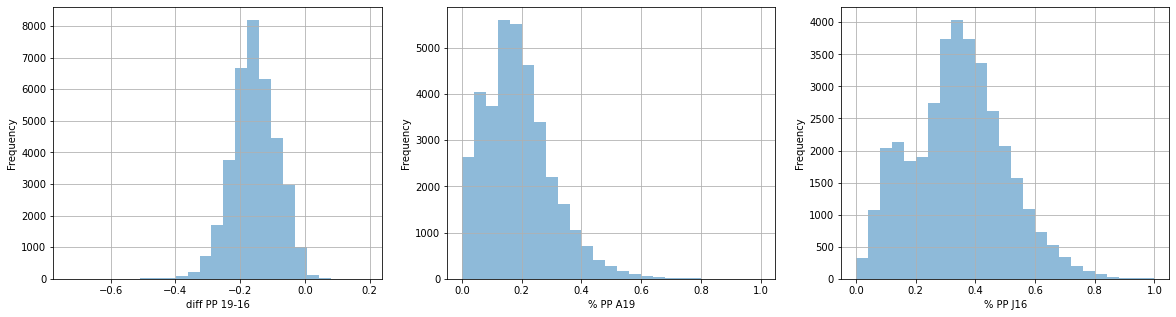

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
df_eleccion_A19_merged['Dif PP 16-19'].plot.hist(alpha=0.5, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('diff PP 19-16')

plt.subplot(1,3,2)
df_eleccion_A19_merged['% PP'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PP A19')

plt.subplot(1,3,3)
df_eleccion_A19_merged['% PP J16'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PP J16')

plt.show()

Hay 12 filas donde no tenemos datos de la columna objetivo, por lo que tendremos que eliminarlas después.

In [ ]:
df_eleccion_A19_merged.loc[df_eleccion_A19_merged['Dif PP 16-19'].isna()]

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,cercana J16_ref,% PP J16,Dif PP 16-19
3371,022019041012306001002,01,23,23060,2306001002,Andalucía,Jaén,Martos,921,512,0.555917,7,505,4,501,34,318,39,47,0,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,...,98,105,84,71,53,45,40,50,36,2,1,0,1391,713,678,0.163192,0.588785,0.248023,12359.0,0.106319,8.884975,2712.0,0.367625,0.466814,0.179948,6291.0,5212.0,16763.0,14032.0,3540.0,2574.0,1777.0,1616.0,536.0,538.0,"{'PP': 34, 'PSOE': 318, 'Cs': 39, 'UP': 47, 'I...","[('PSOE', 318), ('VOX', 56), ('UP', 47), ('Cs'...",022016061012306001002,NaN,NaN
5592,022019041014109105035,01,41,41091,4109105035,Andalucía,Sevilla,Sevilla,1284,816,0.635514,5,811,4,807,23,486,39,188,0,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,8,...,119,132,128,89,56,73,72,51,38,15,2,0,1662,784,878,0.184717,0.605295,0.209988,353325.0,0.104708,212.590253,84383.0,0.414515,0.517901,0.192784,5888.0,5314.0,15395.0,14544.0,3233.0,2603.0,2215.0,1989.0,356.0,442.0,"{'PP': 23, 'PSOE': 486, 'Cs': 39, 'UP': 188, '...","[('PSOE', 486), ('UP', 188), ('VOX', 56), ('Cs...",022016061014109105035,NaN,NaN
8187,022019041033306002001,03,33,33060,3306002001,Asturias,Asturias,San Martín del Rey Aurelio,1673,1159,0.692767,21,1138,12,1126,162,472,119,280,0,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,17,...,127,117,169,230,179,136,87,60,59,24,1,0,1878,914,964,0.290735,0.592652,0.116613,2364.0,0.298646,1.258786,2120.0,0.522642,0.559434,0.472792,11272.0,11846.0,25277.0,26993.0,4664.0,4491.0,7212.0,6839.0,195.0,392.0,"{'PP': 162, 'PSOE': 472, 'Cs': 119, 'UP': 280,...","[('PSOE', 472), ('UP', 280), ('PP', 162), ('Cs...",022016061033306002002,NaN,NaN
10568,022019041063907502007,06,39,39075,3907502007,Cantabria,Cantabria,Santander,685,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,56,64,63,56,59,55,38,43,29,10,3,3,882,385,497,0.272109,0.574830,0.153061,91873.0,0.105613,104.164399,14572.0,0.452443,0.535479,0.136897,12844.0,12948.0,30563.0,30188.0,8117.0,7790.0,5171.0,5126.0,232.0,287.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0...","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),...",022016061063907502007,0.454352,NaN
10898,022019041070200307011,07,02,02003,0200307011,Castilla y León,Albacete,Albacete,1185,378,0.318987,5,373,0,373,33,275,17,18,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,...,131,97,65,52,26,30,11,11,5,1,0,1,2022,1008,1014,0.042038,0.539070,0.418892,72704.0,0.152756,35.956479,18186.0,0.382822,0.487188,0.200088,3431.0,3281.0,12240.0,11388.0,1767.0,1349.0,629.0,626.0,577.0,574.0,"{'PP': 33, 'PSOE': 275, 'Cs': 17, 'UP': 18, 'I...","[('PSOE', 275), ('PP', 33), ('VOX', 21), ('UP'...",022016061070200307012,NaN,NaN
13773,022019041082408903009,08,24,24089,2408903009,Castilla - La Mancha,León,León,1159,971,0.837791,4,967,4,963,235,287,220,89,0,115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,8,...,129,193,132,112,69,79,40,48,30,8,0,0,1421,664,757,0.192822,0.602393,0.204785,63898.0,0.128439,44.966925,11285.0,0.429154,0.528135,0.150100,14674.0,7350.0,36866.0,16938.0,11711.0,3394.0,4021.0,2830.0,165.0,326.0,"{'PP': 235, 'PSOE': 287, 'Cs': 220, 'UP': 89, ...","[('PSOE', 287), ('PP', 235), ('Cs', 220), ('VO...",022016061082408903022,NaN,NaN
14870,022019041083735701001,08,37,37357,3735701001,Castilla - La Mancha,Salaman

In [ ]:
df_eleccion_A19_merged.describe()

,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,% PP,% PSOE,% UP,% Vox,% Cs,% IU,0-4,5-9,...,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,% PP J16,Dif PP 16-19
count,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.0,36317.000000,36317.0,36317.0,36317.0,36317.000000,36317.000000,36317.0,36317.0,36317.000000,36317.000000,36317.0,36317.000000,36317.0,36317.0,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36315.000000,36315.000000,36315.000000,36315.000000,36315.000000,36315.0,36317.000000,36317.000000,...,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,3.627100e+04,36271.000000,36271.000000,36303.000000,36303.000000,36303.000000,36271.000000,36178.000000,36178.000000,36178.000000,36178.000000,34041.000000,34041.000000,34041.000000,34041.000000,34041.000000,34041.000000,36307.000000,36305.000000
mean,958.261117,725.824903,0.758828,7.581408,718.243495,5.482749,712.760746,122.912851,206.010050,113.907674,103.239089,0.0,73.707134,0.0,0.0,0.0,27.964645,13.715533,0.0,0.0,10.867665,7.127461,0.0,3.778258,0.0,0.0,2.583170,1.436132,0.611614,4.761021,8.971886,11.166561,0.188463,0.291067,0.136721,0.102196,0.151376,0.0,56.135226,64.859267,...,78.761737,96.169838,110.514800,105.155189,100.169067,89.956467,77.074400,66.051574,59.912438,44.553212,37.277694,26.853732,11.442245,2.852851,0.448908,1294.881405,634.480491,660.400914,0.222335,0.600481,0.177183,2.150336e+05,0.230943,173.219401,28027.931493,0.428061,0.528475,0.210434,11505.018739,10869.106348,29477.534003,28020.872928,8314.100367,7306.835867,3178.389679,2940.963073,289.498314,346.348407,0.343197,-0.154731
std,437.906979,344.834412,0.073586,6.115915,341.724321,4.412176,339.188435,87.894068,112.301806,82.379609,68.731923,0.0,59.657869,0.0,0.0,0.0,82.872402,46.136236,0.0,0.0,55.301269,36.134619,0.0,24.598082,0.0,0.0,12.183276,14.238636,6.648651,19.875036,7.112796,18.314118,0.114328,0.102823,0.061077,0.060154,0.065176,0.0,45.273236,50.291796,...,49.876737,66.621546,75.273439,65.453286,55.428526,46.961287,41.709315,38.432323,36.645395,26.556226,21.207614,16.397375,8.493468,2.887382,0.832193,653.478204,326.033879,330.748408,0.095902,0.054204,0.060463,5.192026e+05,0.157414,446.946651,56141.160612,0.091417,0.097089,0.103300,3650.026093,3530.809436,10092.134163,9698.750682,3576.994175,3383.289953,1401.570239,1250.000095,119.816182,118.278271,0.157465,0.069405
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000

##Datset de Train

Ahora ya procedemos como con otro modelo de regresión. Para empezar, separamos entre train y test, y nos quedamos con el dataser de train.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_eleccion_A19_merged, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/train_set_lasso_dif_PP_16_19.txt', index=False)
test.to_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/test_set_lasso_dif_PP_16_19.txt', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df_train = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/train_set_lasso_dif_PP_16_19.txt',  dtype = strings)

Dimensiones del dataset de training: (29053, 100)
Dimensiones del dataset de test: (7264, 100)


In [ ]:
df_train

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,cercana J16_ref,% PP J16,Dif PP 16-19
0,022019041113605701001,11,36,36057,3605701001,Extremadura,Pontevedra,Vigo,790,607,0.768354,11,596,4,592,95,230,72,135,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,13,3,...,83,73,62,56,56,86,43,40,33,12,3,0,1037,485,552,0.263259,0.564127,0.172613,137835.0,0.132564,132.917068,30079.0,0.433292,0.539346,0.179133,10249.0,9681.0,24932.0,23853.0,6997.0,5506.0,3853.0,4029.0,325.0,399.0,"{'PP': 95, 'PSOE': 230, 'Cs': 72, 'UP': 135, '...","[('PSOE', 230), ('UP', 135), ('PP', 95), ('Cs'...",022016061113605701001,0.278947,-0.119551
1,022019041122801303008,12,28,28013,2801303008,Galicia,Madrid,Aranjuez,1237,878,0.709782,8,870,13,857,135,238,181,143,0,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,13,...,128,154,114,112,60,51,37,48,66,43,17,3,1502,699,803,0.216378,0.593875,0.189747,14994.0,0.186675,9.982690,5180.0,0.406757,0.490927,0.256766,11968.0,11003.0,38245.0,36290.0,11471.0,9729.0,2131.0,1914.0,243.0,281.0,"{'PP': 135, 'PSOE': 238, 'Cs': 181, 'UP': 143,...","[('PSOE', 238), ('Cs', 181), ('UP', 143), ('PP...",022016061122801303008,0.353393,-0.198221
2,022019041071910301001,07,19,19103,1910301001,Castilla y León,Guadalajara,Checa,251,218,0.868526,2,216,1,215,65,90,19,12,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,16,19,33,19,20,16,17,18,17,9,1,0,282,172,110,0.347518,0.560284,0.092199,59.0,0.610169,0.209220,17.0,0.647059,0.470588,0.223684,11882.0,10383.0,23170.0,20407.0,9044.0,6751.0,3908.0,3371.0,176.0,230.0,"{'PP': 65, 'PSOE': 90, 'Cs': 19, 'UP': 12, 'IU...","[('PSOE', 90), ('PP', 65), ('VOX', 28), ('Cs',...",022016061071910301001,0.437500,-0.136574
3,022019041100601201002,10,06,06012,0601201002,C. Valenciana,Badajoz,Arroyo de San Serván,1011,794,0.785361,7,787,4,783,122,431,81,60,0,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,...,67,101,101,73,51,60,56,38,34,9,5,0,1237,629,608,0.204527,0.613581,0.181892,1483.0,0.226568,1.198868,707.0,0.373409,0.514851,0.322831,7174.0,6773.0,17583.0,17611.0,3733.0,2949.0,1957.0,2096.0,719.0,670.0,"{'PP': 122, 'PSOE': 431, 'Cs': 81, 'UP': 60, '...","[('PSOE', 431), ('PP', 122), ('VOX', 82), ('Cs...",022016061100601201002,0.325352,-0.170333
4,022019041011400501003,01,14,14005,1400501003,Andalucía,Córdoba,Almodóvar del Río,758,543,0.716359,15,528,7,521,76,185,80,130,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,3,...,64,84,63,47,41,32,36,26,30,8,1,0,951,455,496,0.182965,0.589905,0.227129,2119.0,0.181218,2.228181,1490.0,0.393960,0.522819,0.412857,7646.0,7094.0,19859.0,18347.0,5392.0,4172.0,2168.0,2158.0,616.0,653.0,"{'PP': 76, 'PSOE': 185, 'Cs': 80, 'UP': 130, '...","[('PSOE', 185), ('UP', 130), ('Cs', 80), ('PP'...",022016061011400501003,0.268859,-0.124919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29048,022019041092521704001,09,25,25217,2521704001,Cataluña,Lérida,Tàrrega,560,389,0.694643,1,388,5,383,16,43,29,27,0,9,0,0,0,129,115,0,0,0,0,0,0,0,0,0,0,0,0,4,11,...,38,63,72,61,54,30,16,27,19,16,7,0,920,438,482,0.183696,0.621739,

In [ ]:
cols_iniciales = df_train.columns

In [ ]:
cols_iniciales

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

Nos quedamos con las columnas socioeconómicas, que son las que queremos modelizar, descartando las de porcentajes de votos, excepto la objetivo, por supuesto.

In [ ]:
cols_validas = ['Provincia',
        'Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       'Dif PP 16-19']

In [ ]:
df_train = df_train[cols_validas]

In [ ]:
df_train

,Provincia,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,Dif PP 16-19
0,Pontevedra,790,0.768354,42,50,39,48,42,56,48,82,83,83,73,62,56,56,86,43,40,33,12,3,0,1037,485,552,0.263259,0.564127,0.172613,137835.0,0.132564,132.917068,30079.0,0.433292,0.539346,0.179133,10249.0,9681.0,24932.0,23853.0,6997.0,5506.0,3853.0,4029.0,325.0,399.0,-0.119551
1,Madrid,1237,0.709782,42,45,83,115,101,69,85,45,84,128,154,114,112,60,51,37,48,66,43,17,3,1502,699,803,0.216378,0.593875,0.189747,14994.0,0.186675,9.982690,5180.0,0.406757,0.490927,0.256766,11968.0,11003.0,38245.0,36290.0,11471.0,9729.0,2131.0,1914.0,243.0,281.0,-0.198221
2,Guadalajara,251,0.868526,5,5,7,9,4,7,19,23,18,16,19,33,19,20,16,17,18,17,9,1,0,282,172,110,0.347518,0.560284,0.092199,59.0,0.610169,0.209220,17.0,0.647059,0.470588,0.223684,11882.0,10383.0,23170.0,20407.0,9044.0,6751.0,3908.0,3371.0,176.0,230.0,-0.136574
3,Badajoz,1011,0.785361,60,58,54,53,77,90,91,83,76,67,101,101,73,51,60,56,38,34,9,5,0,1237,629,608,0.204527,0.613581,0.181892,1483.0,0.226568,1.198868,707.0,0.373409,0.514851,0.322831,7174.0,6773.0,17583.0,17611.0,3733.0,2949.0,1957.0,2096.0,719.0,670.0,-0.170333
4,Córdoba,758,0.716359,54,54,58,50,40,67,54,78,64,64,84,63,47,41,32,36,26,30,8,1,0,951,455,496,0.182965,0.589905,0.227129,2119.0,0.181218,2.228181,1490.0,0.393960,0.522819,0.412857,7646.0,7094.0,19859.0,18347.0,5392.0,4172.0,2168.0,2158.0,616.0,653.0,-0.124919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29048,Lérida,560,0.694643,40,44,55,40,63,54,69,83,69,38,63,72,61,54,30,16,27,19,16,7,0,920,438,482,0.183696,0.621739,0.194565,6412.0,0.209607,6.969565,1228.0,0.383550,0.506515,0.160733,10904.0,11208.0,27543.0,25572.0,7230.0,6682.0,3238.0,3392.0,269.0,271.0,-0.094057
29049,Murcia,561,0.814617,36,58,52,52,39,48,29,56,72,79,61,32,25,43,23,19,17,9,0,0,0,750,365,385,0.148000,0.588000,0.264000,220555.0,0.135699,294.073333,40847.0,0.402184,0.479448,0.156261,9491.0,8590.0,26916.0,24345.0,7627.0,6765.0,2071.0,1782.0,227.0,289.0,-0.272166
29050,Vizcaya,513,0.807018,17,11,13,19,25,20,24,34,34,49,47,43,42,33,55,46,24,30,14,3,0,583,261,322,0.351630,0.545455,0.102916,12349.0,0.196696,21.181818,5768.0,0.445735,0.480583,0.318375,16267.0,15427.0,35715.0,35879.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.034481
29051,Tarragona,1041,0.669549,134,118,124,75,108,106,123,188,182,136,121,100,106,94,72,58,48,27,10,6,1,1937,983,954,0.163139,0.604027,0.232834,14852.0,0.151697,7.667527,2746.0,0.483248,0.520393,0.156040,8499.0,8229.0,24419.0,23679.0,5903.0,5285.0,2392.0,2558.0,318.0,405.0,-0.096217


In [ ]:
df_train.dtypes

Provincia                            object
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

La mayor parte de las columnas no tienen datos nan...

In [ ]:
df_train.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,Dif PP 16-19
count,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,2.901900e+04,29019.000000,29019.000000,29042.000000,29042.000000,29042.000000,29019.000000,28927.000000,28927.000000,28927.000000,28927.000000,27207.000000,27207.000000,27207.000000,27207.00000,27207.000000,27207.000000,29043.000000
mean,956.698620,0.758225,55.979555,64.732041,68.540977,63.875916,63.430145,70.589061,78.593157,95.926686,110.241145,104.983651,100.020067,89.869411,77.090146,66.079441,59.869239,44.541218,37.272846,26.805390,11.435687,2.848794,0.450418,1293.174991,633.628610,659.546381,0.222423,0.600480,0.177097,2.131663e+05,0.231285,171.994358,27899.223504,0.428165,0.528409,0.210673,11481.390398,10848.000703,29414.936055,27967.754271,8283.665447,7277.752872,3176.861782,2939.01193,289.773974,346.626932,-0.154490
std,437.769889,0.073920,44.964268,50.275843,49.716201,42.149367,37.507779,40.991249,49.409638,66.171139,75.117674,65.310899,55.332556,47.021672,41.950023,38.688731,36.909974,26.703108,21.331781,16.436542,8.548030,2.893223,0.835001,653.981388,325.959982,331.175161,0.095884,0.054285,0.060523,5.163886e+05,0.158011,445.088345,55886.671589,0.091630,0.096999,0.103397,3636.000670,3514.183923,10045.065165,9649.670139,3545.583225,3353.678770,1403.171191,1249.94899,119.433969,117.927213,0.069412
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.00000,71.000000,81.000000,-0.730769
25%,690.000000,0.719570,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,431.000000,462.000000,0.159597,0.572816,0.143734,1.845000e+03,0.121701,1.320845,573.000000,0.398112,0.488372,0.138889,9092.000000,8508.500000,23195.500000,21899.000000,5966.500000,5045.000000,2208.000000,2071.00000,216.000000,275.000000,-0.198668
50%,952.000000,0.765988,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,610.000000,650.000000,0.211869,0.605886,0.176874,1.431700e+04,0.179074,9.809769,4240.000000,0.421271,0.525886,0.192784,10905.000000,10269.000000,27569.000000,26156.000000,7703.000000,6725.000000,2992.000000,2782.00000,269.000000,335.000000,-0.155505
75%,1239.000000,0.807240,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.000000,860.000000,0.272635,0.633694,0.212171,9.949500e+04,0.280890,80.752151,22481.00000

...pero hay algunas que sí, asi que los rellenamos en función de la media de cada columna.

In [ ]:
FillNA_num_mean = ['Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [ ]:
for item in FillNA_num_mean:
        
    df_train[item].fillna(df_train[item].mean(), inplace=True)

In [ ]:
df_train.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,Dif PP 16-19
count,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,2.905300e+04,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29043.000000
mean,956.698620,0.758225,55.979555,64.732041,68.540977,63.875916,63.430145,70.589061,78.593157,95.926686,110.241145,104.983651,100.020067,89.869411,77.090146,66.079441,59.869239,44.541218,37.272846,26.805390,11.435687,2.848794,0.450418,1293.174991,633.628610,659.546381,0.222423,0.600480,0.177097,2.131663e+05,0.231285,171.994358,27899.223504,0.428165,0.528409,0.210673,11481.390398,10848.000703,29414.936055,27967.754271,8283.665447,7277.752872,3176.861782,2939.011930,289.773974,346.626932,-0.154490
std,437.769889,0.073920,44.964268,50.275843,49.716201,42.149367,37.507779,40.991249,49.409638,66.171139,75.117674,65.310899,55.332556,47.021672,41.950023,38.688731,36.909974,26.703108,21.331781,16.436542,8.548030,2.893223,0.835001,653.981388,325.959982,331.175161,0.095884,0.054285,0.060523,5.160863e+05,0.157919,444.827822,55876.090363,0.091613,0.096981,0.103336,3628.107342,3506.555045,10023.258516,9628.721846,3431.089234,3245.381758,1357.859980,1209.585631,115.577207,114.119107,0.069412
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,-0.730769
25%,690.000000,0.719570,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,431.000000,462.000000,0.159597,0.572816,0.143734,1.846000e+03,0.121701,1.325815,574.000000,0.398112,0.488397,0.138930,9099.000000,8517.000000,23213.000000,21918.000000,6082.000000,5159.000000,2265.000000,2121.000000,220.000000,280.000000,-0.198668
50%,952.000000,0.765988,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,610.000000,650.000000,0.211869,0.605886,0.176874,1.434400e+04,0.179083,9.850248,4240.000000,0.421271,0.525926,0.192784,10924.000000,10286.000000,27618.000000,26199.000000,7855.336603,6845.948425,3110.000000,2889.000000,277.000000,343.000000,-0.155505
75%,1239.000000,0.807240,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.000000,860.000000,0.272635,0.633694,0.212171,9.949500e+04,0.280792,81.265306,22481

Ahora toca tratar la columna categórica, la Provincia, algo que hacemos sin mayor novedad.

In [ ]:
categorical = ['Provincia']

In [ ]:
df_train['Provincia'].value_counts().sum()

29053

In [ ]:
mean_map1 = {}
for c in categorical:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_train.groupby(c)['Dif PP 16-19'].mean()
    df_train[c] = df_train[c].map(mean)    
    mean_map1[c] = mean

In [ ]:
mean_map1

{'Provincia': Provincia
 Albacete                 -0.184459
 Alicante                 -0.178808
 Almería                  -0.199951
 Asturias                 -0.171947
 Badajoz                  -0.184882
 Barcelona                -0.085504
 Burgos                   -0.185192
 Cantabria                -0.198728
 Castellón                -0.151666
 Ceuta                    -0.282892
 Ciudad Real              -0.193174
 Cuenca                   -0.179341
 Cáceres                  -0.170240
 Cádiz                    -0.168013
 Córdoba                  -0.150864
 Gerona                   -0.066772
 Gipúzcoa                 -0.043930
 Granada                  -0.162090
 Guadalajara              -0.180379
 Huelva                   -0.154026
 Huesca                   -0.157685
 Islas Baleares           -0.181543
 Jaén                     -0.154825
 La Coruña                -0.142924
 La Rioja                 -0.150526
 Las Palmas               -0.176428
 León                     -0.167926
 Lug

In [ ]:
df_train.dtypes

Provincia                           float64
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

Hacemos un describe de las columnas. A tener en cuenta es la std de la columna objetivo, cerca del 0.07, para compararla con los errores que obtengamos con Lasso.

In [ ]:
df_train.describe()

,Provincia,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,Dif PP 16-19
count,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,2.905300e+04,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29043.000000
mean,-0.154490,956.698620,0.758225,55.979555,64.732041,68.540977,63.875916,63.430145,70.589061,78.593157,95.926686,110.241145,104.983651,100.020067,89.869411,77.090146,66.079441,59.869239,44.541218,37.272846,26.805390,11.435687,2.848794,0.450418,1293.174991,633.628610,659.546381,0.222423,0.600480,0.177097,2.131663e+05,0.231285,171.994358,27899.223504,0.428165,0.528409,0.210673,11481.390398,10848.000703,29414.936055,27967.754271,8283.665447,7277.752872,3176.861782,2939.011930,289.773974,346.626932,-0.154490
std,0.046695,437.769889,0.073920,44.964268,50.275843,49.716201,42.149367,37.507779,40.991249,49.409638,66.171139,75.117674,65.310899,55.332556,47.021672,41.950023,38.688731,36.909974,26.703108,21.331781,16.436542,8.548030,2.893223,0.835001,653.981388,325.959982,331.175161,0.095884,0.054285,0.060523,5.160863e+05,0.157919,444.827822,55876.090363,0.091613,0.096981,0.103336,3628.107342,3506.555045,10023.258516,9628.721846,3431.089234,3245.381758,1357.859980,1209.585631,115.577207,114.119107,0.069412
min,-0.282892,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,-0.730769
25%,-0.188954,690.000000,0.719570,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,431.000000,462.000000,0.159597,0.572816,0.143734,1.846000e+03,0.121701,1.325815,574.000000,0.398112,0.488397,0.138930,9099.000000,8517.000000,23213.000000,21918.000000,6082.000000,5159.000000,2265.000000,2121.000000,220.000000,280.000000,-0.198668
50%,-0.168013,952.000000,0.765988,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,610.000000,650.000000,0.211869,0.605886,0.176874,1.434400e+04,0.179083,9.850248,4240.000000,0.421271,0.525926,0.192784,10924.000000,10286.000000,27618.000000,26199.000000,7855.336603,6845.948425,3110.000000,2889.000000,277.000000,343.000000,-0.155505
75%,-0.138621,1239.000000,0.807240,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.

Comprobamos ahora la correlación entre las columnas.

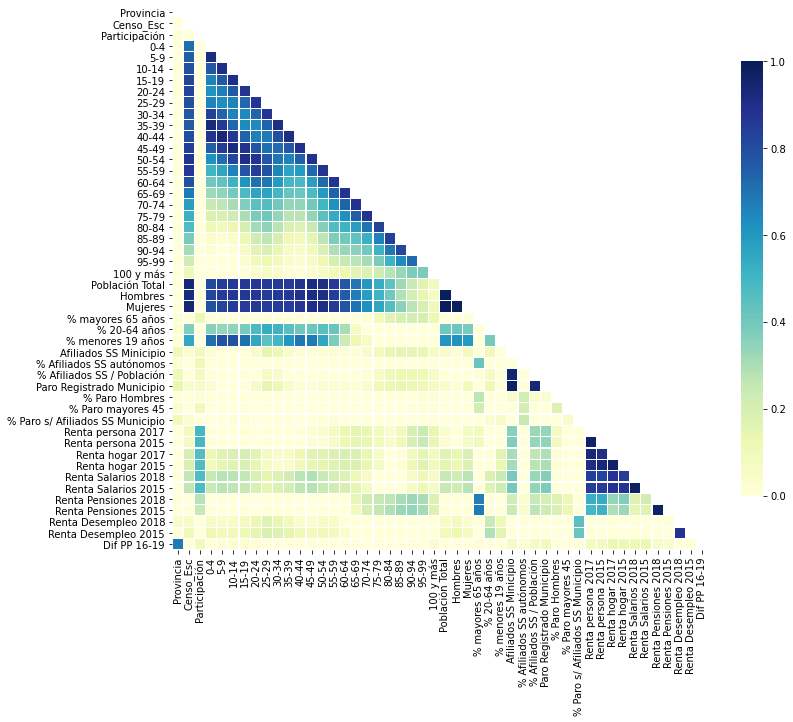

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Vemos que existen las habituales entre las rentas, y una muy importante entre la provincia y nuestra variable objetivo.

In [ ]:
df_train.columns

Index(['Provincia', 'Censo_Esc', 'Participación', '0-4', '5-9', '10-14',
       '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
       '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94',
       '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       'Dif PP 16-19'],
      dtype='object')

Como hacemos en otros cuadernos, eliminamos las columans más correlacionadas.

In [ ]:
df_train = df_train.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_train

,Provincia,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta hogar 2017,Renta Salarios 2018,Renta Pensiones 2018,Renta Desempleo 2018,Dif PP 16-19
0,-0.130109,790,0.768354,42,50,39,48,42,56,48,82,83,83,73,62,56,56,86,43,40,33,12,3,0,1037,0.263259,0.564127,0.172613,137835.0,0.132564,132.917068,30079.0,0.433292,0.539346,0.179133,10249.0,24932.0,6997.000000,3853.000000,325.000000,-0.119551
1,-0.188954,1237,0.709782,42,45,83,115,101,69,85,45,84,128,154,114,112,60,51,37,48,66,43,17,3,1502,0.216378,0.593875,0.189747,14994.0,0.186675,9.982690,5180.0,0.406757,0.490927,0.256766,11968.0,38245.0,11471.000000,2131.000000,243.000000,-0.198221
2,-0.180379,251,0.868526,5,5,7,9,4,7,19,23,18,16,19,33,19,20,16,17,18,17,9,1,0,282,0.347518,0.560284,0.092199,59.0,0.610169,0.209220,17.0,0.647059,0.470588,0.223684,11882.0,23170.0,9044.000000,3908.000000,176.000000,-0.136574
3,-0.184882,1011,0.785361,60,58,54,53,77,90,91,83,76,67,101,101,73,51,60,56,38,34,9,5,0,1237,0.204527,0.613581,0.181892,1483.0,0.226568,1.198868,707.0,0.373409,0.514851,0.322831,7174.0,17583.0,3733.000000,1957.000000,719.000000,-0.170333
4,-0.150864,758,0.716359,54,54,58,50,40,67,54,78,64,64,84,63,47,41,32,36,26,30,8,1,0,951,0.182965,0.589905,0.227129,2119.0,0.181218,2.228181,1490.0,0.393960,0.522819,0.412857,7646.0,19859.0,5392.000000,2168.000000,616.000000,-0.124919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29048,-0.079992,560,0.694643,40,44,55,40,63,54,69,83,69,38,63,72,61,54,30,16,27,19,16,7,0,920,0.183696,0.621739,0.194565,6412.0,0.209607,6.969565,1228.0,0.383550,0.506515,0.160733,10904.0,27543.0,7230.000000,3238.000000,269.000000,-0.094057
29049,-0.232578,561,0.814617,36,58,52,52,39,48,29,56,72,79,61,32,25,43,23,19,17,9,0,0,0,750,0.148000,0.588000,0.264000,220555.0,0.135699,294.073333,40847.0,0.402184,0.479448,0.156261,9491.0,26916.0,7627.000000,2071.000000,227.000000,-0.272166
29050,-0.052946,513,0.807018,17,11,13,19,25,20,24,34,34,49,47,43,42,33,55,46,24,30,14,3,0,583,0.351630,0.545455,0.102916,12349.0,0.196696,21.181818,5768.0,0.445735,0.480583,0.318375,16267.0,35715.0,8283.665447,3176.861782,289.773974,-0.034481
29051,-0.092806,1041,0.669549,134,118,124,75,108,106,123,188,182,136,121,100,106,94,72,58,48,27,10,6,1,1937,0.163139,0.604027,0.232834,14852.0,0.151697,7.667527,2746.0,0.483248,0.520393,0.156040,8499.0,24419.0,5903.000000,2392.000000,318.000000,-0.096217


Nos quedamos con las filas cuya variable objetivo no es nula.

In [ ]:
df_train = df_train[df_train['Dif PP 16-19'].notnull()]

In [ ]:
df_train.describe()

,Provincia,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta hogar 2017,Renta Salarios 2018,Renta Pensiones 2018,Renta Desempleo 2018,Dif PP 16-19
count,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,2.904300e+04,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000,29043.000000
mean,-0.154490,956.662604,0.758297,55.983852,64.736391,68.543814,63.876425,63.429983,70.588748,78.595255,95.932307,110.247530,104.987260,100.017113,89.864339,77.082912,66.074992,59.863409,44.537272,37.266088,26.799160,11.433908,2.848776,0.450401,1293.159935,0.222406,0.600489,0.177105,2.132098e+05,0.231287,172.033358,27902.114880,0.428160,0.528407,0.210672,11481.856876,29416.823338,8284.434410,3176.496798,289.785025,-0.154490
std,0.046697,437.784990,0.073644,44.968805,50.281682,49.720996,42.151546,37.511247,40.994222,49.415021,66.179198,75.127147,65.317622,55.335415,47.021958,41.941717,38.684605,36.909438,26.704532,21.330359,16.433966,8.547376,2.893466,0.834969,654.039655,0.095879,0.054286,0.060521,5.161660e+05,0.157910,444.897715,55883.433881,0.091624,0.096990,0.103339,3628.278798,10023.721555,3431.078397,1357.566284,115.575665,0.069412
min,-0.282892,3.000000,0.028986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,12087.000000,1767.000000,345.000000,71.000000,-0.730769
25%,-0.188954,690.000000,0.719657,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,0.159587,0.572805,0.143738,1.846000e+03,0.121701,1.325825,574.000000,0.398112,0.488397,0.138930,9099.000000,23214.500000,6084.000000,2265.000000,220.000000,-0.198668
50%,-0.168013,952.000000,0.766029,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1261.000000,0.211864,0.605894,0.176875,1.434400e+04,0.179083,9.846857,4240.000000,0.421271,0.525886,0.192784,10924.000000,27620.000000,7855.336603,3110.000000,277.000000,-0.155505
75%,-0.138621,1239.000000,0.807268,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,0.272584,0.633706,0.212184,9.949500e+04,0.280792,81.237952,22481.000000,0.442646,0.547041,0.274113,12919.000000,32795.500000,9547.500000,3799.500000,322.000000,-0.107385
max,-0.033833,3480.000000,1.000000,650.000000,560.000000,468.000000,365.000000,362.000000,491.000000,647.000000,854.000000,918.000000,704.000000,718.000000,957.000000,1256.000000,1740.000000,2105.000000,1262.000000,591.000000,193.000000,145.000000,51.000000,20.000000,11747.000000,0.857143,1.000000,0.458289,1.996269e+06,1.000000,3355.073950,220332.000000,1.000000,1.000000,0.777778,30210.000000,86006.000000,26674.000000,8302.000000,846.000000

Y por fin definimos el vector y y la matriz X del dataset de train

In [ ]:
y_train = df_train['Dif PP 16-19']

In [ ]:
y_train

0       -0.119551
1       -0.198221
2       -0.136574
3       -0.170333
4       -0.124919
           ...   
29048   -0.094057
29049   -0.272166
29050   -0.034481
29051   -0.096217
29052   -0.107945
Name: Dif PP 16-19, Length: 29043, dtype: float64

In [ ]:
X_train = df_train.drop(['Dif PP 16-19'], axis = 1)

In [ ]:
X_train.shape

(29043, 40)

In [ ]:
y_train.shape

(29043,)

##Datset de Test

Pasamos ahora al dataset de test, al que aplicaremos los mismos pasos que al de train, y en el mismo orden.

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/test_set_lasso_dif_PP_16_19.txt',  dtype = strings)

In [ ]:
df_test

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,cercana J16_ref,% PP J16,Dif PP 16-19
0,022019041082408910003,08,24,24089,2408910003,Castilla - La Mancha,León,León,638,480,0.752351,8,472,4,468,105,151,82,61,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,9,...,55,55,66,41,38,45,25,52,38,17,5,0,783,335,448,0.280971,0.556833,0.162197,63898.0,0.128439,81.606641,11285.0,0.429154,0.528135,0.150100,11009.0,10229.0,23550.0,21824.0,6997.0,5837.0,4398.0,4420.0,177.0,253.0,"{'PP': 105, 'PSOE': 151, 'Cs': 82, 'UP': 61, '...","[('PSOE', 151), ('PP', 105), ('Cs', 82), ('UP'...",022016061082408910003,0.404255,-0.181798
1,022019041084718603004,08,47,47186,4718603004,Castilla - La Mancha,Valladolid,Valladolid,736,597,0.811141,0,597,9,588,130,159,131,81,0,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,4,...,90,75,61,65,39,42,43,38,19,17,4,0,911,394,517,0.221734,0.615807,0.162459,146297.0,0.113782,160.589462,24645.0,0.426375,0.532684,0.144172,12114.0,11259.0,27930.0,27039.0,9269.0,7373.0,3657.0,3545.0,207.0,197.0,"{'PP': 130, 'PSOE': 159, 'Cs': 131, 'UP': 81, ...","[('PSOE', 159), ('Cs', 131), ('PP', 130), ('UP...",022016061084718603004,0.407942,-0.190187
2,022019041053800601012,05,38,38006,3800601012,Canarias,Santa Cruz de Tenerife,Arona,875,504,0.576000,7,497,3,494,79,173,61,50,0,29,0,0,0,0,0,0,0,0,0,0,87,0,0,0,0,0,0,6,9,...,120,89,89,88,60,38,25,12,12,2,2,0,1282,639,643,0.117785,0.665367,0.216849,30637.0,0.185625,23.897816,8767.0,0.445991,0.514999,0.222490,7499.0,6930.0,22157.0,20318.0,5828.0,4892.0,1629.0,1396.0,447.0,574.0,"{'PP': 79, 'PSOE': 173, 'Cs': 61, 'UP': 50, 'I...","[('PSOE', 173), ('CC', 87), ('PP', 79), ('Cs',...",022016061053800601012,0.373239,-0.214286
3,022019041090801905042,09,08,08019,0801905042,Cataluña,Barcelona,Barcelona,931,779,0.836735,0,779,9,770,80,135,163,51,0,50,0,0,0,148,121,0,0,0,0,0,0,0,0,0,0,0,0,7,15,...,67,94,81,76,56,56,53,52,41,22,6,1,1297,615,682,0.221280,0.596762,0.181958,1134047.0,0.108401,874.361604,87744.0,0.458413,0.535843,0.071816,21924.0,20374.0,51413.0,47815.0,15592.0,13968.0,4605.0,4711.0,146.0,203.0,"{'PP': 80, 'PSOE': 135, 'Cs': 163, 'UP': 51, '...","[('Cs', 163), ('ERC', 148), ('PSOE', 135), ('J...",022016061090801905042,0.260090,-0.157394
4,022019041010407902002,01,04,04079,0407902002,Andalucía,Almería,Roquetas de Mar,1289,884,0.685803,3,881,11,870,210,225,135,82,0,202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,9,...,188,148,122,100,71,65,31,24,9,5,2,0,2265,1196,1069,0.091391,0.657837,0.250773,29256.0,0.262955,12.916556,10769.0,0.436345,0.452410,0.269057,7199.0,6616.0,21454.0,19992.0,4799.0,3931.0,963.0,975.0,468.0,540.0,"{'PP': 210, 'PSOE': 225, 'Cs': 135, 'UP': 82, ...","[('PSOE', 225), ('PP', 210), ('VOX', 202), ('C...",022016061010407902002,0.433041,-0.194676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,022019041122807901087,12,28,28079,2807901087,Galicia,Madrid,Madrid,934,804,0.860814,4,800,4,796,229,177,200,69,0,109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,...,94,127,84,70,46,51,38,25,25,15,3,1,132

Seleccionamos las columnas que utilizaremos finalmente...

In [ ]:
df_test = df_test[cols_validas]

...rellenamos los registros con nan...

In [ ]:
for item in FillNA_num_mean:
        
    df_test[item].fillna(df_test[item].mean(), inplace=True)

In [ ]:
df_test.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,Dif PP 16-19
count,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7.264000e+03,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7262.000000
mean,964.510463,0.761238,56.757847,65.368117,68.839482,64.242704,63.665611,70.971503,79.435986,97.142346,111.609306,105.841272,100.765006,90.304653,77.011426,65.940116,60.085215,44.601184,37.297081,27.047081,11.468475,2.869080,0.442869,1301.706360,637.887665,663.818695,0.221985,0.600487,0.177528,2.225054e+05,0.229574,178.121430,28542.727999,0.427643,0.528740,0.209475,11599.281185,10953.304803,29727.261056,28232.783478,8435.265551,7422.618868,3184.472424,2948.730812,288.400877,345.239563,-0.155695
std,438.429341,0.072187,46.486400,50.355804,49.578011,42.145355,37.483447,42.143865,51.700767,68.389342,75.888578,66.019778,55.810565,46.720593,40.735139,37.391622,35.569481,25.962204,20.704981,16.239465,8.272174,2.864042,0.820894,651.462011,326.329489,329.036556,0.095981,0.053882,0.060227,5.298457e+05,0.154879,453.929190,57136.914978,0.090545,0.097431,0.102826,3700.887721,3592.163777,10265.472868,9881.109672,3586.070072,3391.461365,1353.331309,1212.689717,117.682122,116.071477,0.069372
min,6.000000,0.273438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,3.000000,2.000000,0.007463,0.200000,0.000000,2.000000e+00,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,-0.714286
25%,694.000000,0.722909,29.000000,33.000000,36.000000,36.000000,39.000000,45.000000,48.000000,56.000000,63.000000,63.000000,64.000000,60.000000,51.000000,43.000000,39.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,908.750000,434.000000,468.000000,0.158919,0.572505,0.143781,2.001000e+03,0.121375,1.409837,600.750000,0.397611,0.490343,0.137186,9144.000000,8537.750000,23393.500000,22021.500000,6088.500000,5177.250000,2283.750000,2134.000000,216.000000,276.000000,-0.200443
50%,955.000000,0.767973,48.000000,55.000000,59.000000,57.000000,60.000000,68.000000,73.000000,86.000000,98.000000,95.000000,95.000000,87.000000,74.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1260.000000,610.500000,651.000000,0.212198,0.605347,0.177567,1.382200e+04,0.179083,9.783425,4147.000000,0.420875,0.527070,0.192784,10985.000000,10363.500000,27625.000000,26131.500000,7855.336603,6845.948425,3124.500000,2916.000000,273.000000,339.000000,-0.157149
75%,1251.250000,0.810201,74.000000,86.000000,92.000000,88.000000,85.000000,94.000000,104.000000,125.000000,144.000000,139.000000,132.000000,117.000000,100.000000,86.000000,78.000000,59.000000,50.000000,37.000000,16.000000,4.000000,1.000000,1691.000000,827.000000,865.000000,0.272616,0.633610,0.212706,1.008638e+05,0.280495,81.743621,20869.000000,0.442646,0.547409,0.272727,12990.25000

In [ ]:
df_test.dtypes

Provincia                            object
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

...tratamos la columna de provincias...

In [ ]:
for c in categorical:
    df_test[c] = df_test[c].map(mean_map1[c])

In [ ]:
df_test.dtypes

Provincia                           float64
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

In [ ]:
df_test['Provincia'].describe()

count    7264.000000
mean       -0.154747
std         0.046193
min        -0.282892
25%        -0.188954
50%        -0.168013
75%        -0.138621
max        -0.033833
Name: Provincia, dtype: float64

...eliminamos las columnas demasiado correlacionadas...

In [ ]:
df_test = df_test.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_test.shape

(7264, 41)

y finalmente nos quedamos los registros que tienen la variable objetivo no nula.

In [ ]:
df_test = df_test[df_test['Dif PP 16-19'].notnull()]

Por fin definimos el vector y y la matriz X de test.

In [ ]:
y_test = df_test['Dif PP 16-19']

In [ ]:
X_test = df_test.drop(['Dif PP 16-19'], axis = 1)

In [ ]:
y_test.shape

(7262,)

In [ ]:
X_test.shape

(7262, 40)

Preparamos los vectores y matrices para aplicar SKlearn, aunque por lo visto no haría falta aplicar el método .values()

In [ ]:
columnas = X_train.columns

In [ ]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

##Relevancia de columnas

Ahora buscamos las columnas más significativas mediante F-Test y Mutual Info

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [ ]:
y_train

array([-0.1195514 , -0.19822067, -0.13657407, ..., -0.03448107,
       -0.0962174 , -0.10794509])

In [ ]:
y_test

array([-0.18179769, -0.19018679, -0.21428571, ..., -0.21887524,
       -0.17488369, -0.14662601])

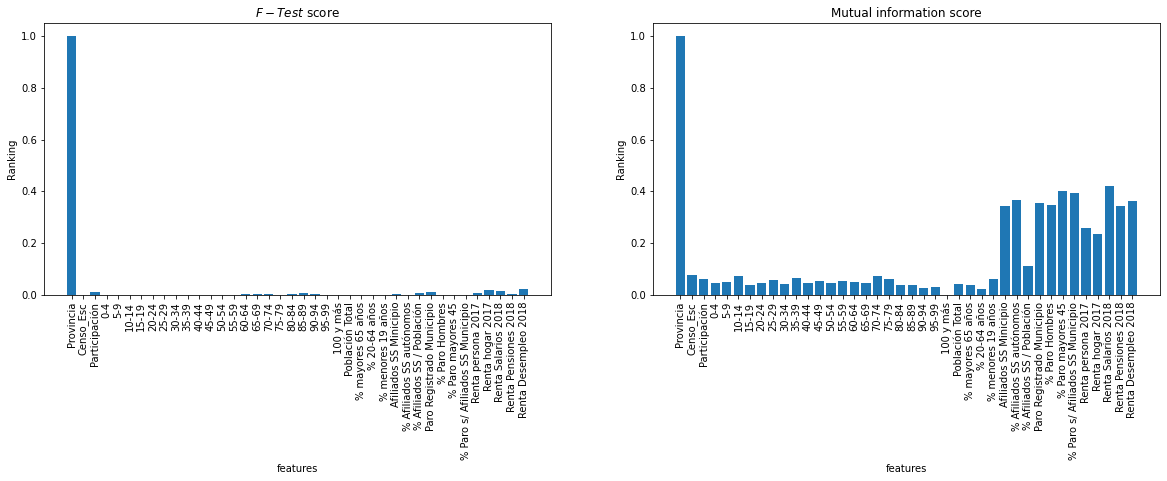

In [ ]:
y = y_train    # nos quedamos con la 1ª columna, price
X = X_train      # nos quedamos con el resto

feature_names = columnas


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Parece que claramente, la diferencia de voto al PP entre 2016 y abril de 2019 se explicaría en su mayor parte por la Provincia, y en mucha menor medida por las rentas.

De cara a Lasso, comviene tener en referencia el número de columnas que pasan de un determinado umbral de MI, en este caso serían unas 12.

In [ ]:
columnas_MI = columnas[mi > 0.2]

In [ ]:
columnas_MI

Index(['Provincia', 'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       'Paro Registrado Municipio', '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta hogar 2017', 'Renta Salarios 2018', 'Renta Pensiones 2018',
       'Renta Desempleo 2018'],
      dtype='object')

In [ ]:
len(columnas_MI)

12

##Modelización con regresión lineal con regularización LASSO

Ahora ya pasamos a modelizar por regresión con regularilización LASSO.

Cargamos las librerías necesarias.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [ ]:
from sklearn import preprocessing

Aplicamos la normalización con el scaler()

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

Comenzamos viendo cómo se van eliminando las columnas a medida que vamos elevando el hiperparámetro alfa. Seguro que la última es la provincia.

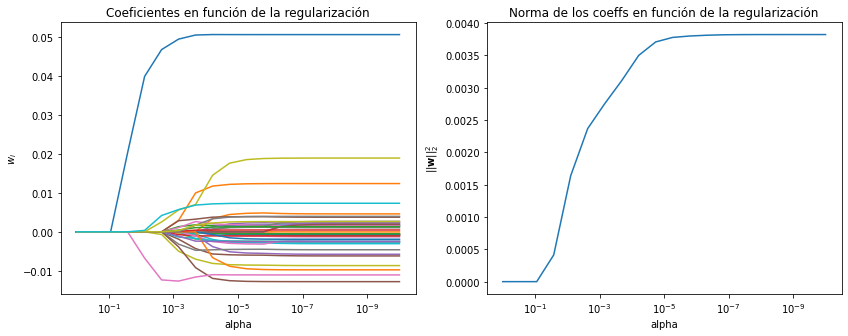

In [ ]:
n_alphas = 20
alphas = np.logspace(-10, 0, n_alphas)
# ...

coefs = []

norm2_coefs = []
for a in alphas:
    #### TU CÓDIGO AQUÍ
    
    lasso = Lasso(alpha=a).fit(XtrainScaled,y_train)
    #####
    coefs.append(lasso.coef_)
    norm2_coefs.append(np.dot(lasso.coef_,lasso.coef_.T))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()

Aplicamos ahora el grid search para optimizar el alfa. o cierto es que por debajo de 10e-3 no parece haber muchos cambios.

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.7min finished


best mean cross-validation score: -0.002
best parameters: {'alpha': 2.06913808111479e-05}


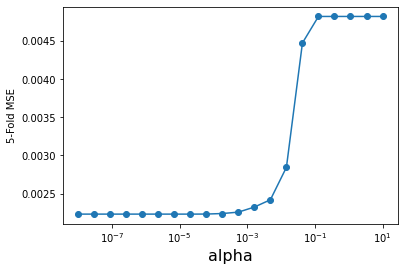

In [ ]:
alpha_vector = np.logspace(-8,1,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10, verbose = 1)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
#plt.ylim(1290, 1330)
plt.show()

Casi por capricho, acotamos el valor óptimo de alfa, que tampoco resulta muy útil en la práctica, como veremos.

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.7min finished


best mean cross-validation score: -0.002233
best parameters: {'alpha': 1.5283067326587687e-05}


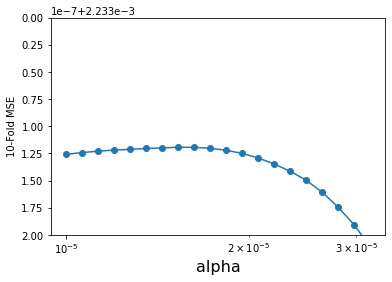

In [ ]:
alpha_vector = np.logspace(-5,-4.5,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10, verbose = 1)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.6f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.ylim(0.0022332, 0.002233)
plt.show()

Usamos en alfa óptimo para modelizar, y lo cierto es que obtenemos un RMSE del 0.047 tanto en test como en train, inferior a la std de la variable objetivo como vimos, lo cual nos hace ver, apriori, que no tenemos un mal modelo.

In [ ]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']

lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.5g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.5g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.5g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.5g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 0.0022249
MSE Modelo Lasso (test) : 0.0021658
RMSE Modelo Lasso (train): 0.047169
RMSE Modelo Lasso (test) : 0.046538
Provincia 0.05066244386997132
Censo_Esc 0.012226577695809943
Participación 0.0015629165507195445
0-4 -0.0002575535999095662
5-9 -0.005204015476852046
10-14 -0.005917687009963782
15-19 -0.0010686837430930675
20-24 -0.004516776755526896
25-29 -0.002399534626728097
30-34 -0.002679610797832257
35-39 0.001526460377495801
40-44 0.004522617363298042
45-49 -0.000570800321748604
50-54 -0.00026397797651599376
55-59 0.002088106068674414
60-64 0.003876447450669057
65-69 0.0018194720631682496
70-74 0.0010779289309579005
75-79 -0.00846528518732069
80-84 -0.002496790354425776
85-89 -0.0006309339276377293
90-94 -0.0
95-99 -0.00047672478272239323
100 y más -0.0010434351228371913
Población Total -0.0
% mayores 65 años -0.0
% 20-64 años -0.002992472725211234
% menores 19 años 0.0012307038593538122
Afiliados SS Minicipio 0.017849907041243278
% Afiliados SS autónom

Sin embargo, vemos que aún hay muchas columnas sin anular con el alfa óptimo. Como el el error apenas variaba con alfas por debajo de 0.001, podemos intentar que pasa si lo ponemos como hiperparámetro.

In [ ]:
from sklearn.metrics import mean_squared_error

# alpha_optimo = grid.best_params_['alpha']

alpha_optimo = 1e-03

lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.5g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.5g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.5g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.5g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 0.0022916
MSE Modelo Lasso (test) : 0.0022235
RMSE Modelo Lasso (train): 0.047871
RMSE Modelo Lasso (test) : 0.047154
Provincia 0.04895099659325472
Censo_Esc 0.0
Participación 0.0007267129273887436
0-4 -0.0
5-9 -0.0
10-14 -0.0005527023145647268
15-19 -0.0
20-24 -0.0014288218156413542
25-29 -0.0
30-34 -0.0
35-39 0.0
40-44 -0.0
45-49 -0.0
50-54 -0.0
55-59 0.0
60-64 0.0025709953873311454
65-69 0.0
70-74 0.0
75-79 -0.0033083093952122424
80-84 -0.0
85-89 -0.0
90-94 -0.0
95-99 -0.0
100 y más -0.00047241452933012785
Población Total -0.0
% mayores 65 años 0.0
% 20-64 años -0.0
% menores 19 años -0.0
Afiliados SS Minicipio 0.004899403727347224
% Afiliados SS autónomos -0.0010948228129892472
% Afiliados SS / Población 0.0
Paro Registrado Municipio 0.0
% Paro Hombres 1.5457594568622934e-05
% Paro mayores 45 0.0
% Paro s/ Afiliados SS Municipio -0.0004154701967967434
Renta persona 2017 -0.0010410350889967733
Renta hogar 2017 -0.014021731789022064
Renta Salarios 2018 -0.0


En efecto, tenemos un error prácticamente igual que antes, pero ahora hemos hecho una gran selección de columnas, concretamente nos quedarían 15, cerca del número que hubiésemos elegido a partir del MI (12), así que es para estar satisfecho.